In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def ImportAndClean(file:str,year:int):
    try:
        if 'NREL' in file:
            #Read in weather file: converting time columns to DateTime, fixing timezone and angle, and selecting used columns
            df = pd.read_csv(file,header=2,usecols=[0,1,2,3,4,20,21])
            df['Date'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
            df = df.set_index('Date')
            #df.index = df.index+pd.Timedelta(hours=-7)
            df['Solar Zenith Angle'] *= np.pi/180
            df = df.drop(columns=['Year','Month','Day','Hour','Minute'])
            df.index.names = ['Date']
            return df
        elif 'environment' in file:
            #Read in environment file: converting time columns to DateTime and selecting used columns
            df = pd.read_csv(file,index_col=[0],usecols=[0,1,9])
            df = df.set_index(pd.to_datetime(df.index))
            df = df.rename(columns={df.columns[0]: "Ambient Temperature",df.columns[1]: "Wind Sensor"})
            df['Ambient Temperature'] += 273
            df.dropna(inplace=True)
            df.index.names = ['Date']
            return df[df.index.year == year]
        elif 'power' in file:
            #Read in power file: converting time columns to DateTime, selecting power columns, and returning energy column
            df = pd.read_csv(file,index_col=0,usecols=[0,9,10])
            df = df.set_index(pd.to_datetime(df.index))
            df['Power'] = df.iloc[:,[0,1]].mean(axis=1)
            #Energy ~ Power*Time
            df['Energy'] = df['Power']/12
            df = df[['Energy']].dropna(axis=0)
            df.index.names = ['Date']
            return df.iloc[df.index.year == year]
            
    except Exception as e:
        print(f'Error: {e}')

In [ ]:
Weather22 = ImportAndClean("../data/NREL_Weather/1000190_40.38_-104.55_2022.csv",2022).tz_localize(tz='UTC',ambiguous='NaT')
Energy22 = ImportAndClean("../data/Data_9068/9068_ac_power_data_2022.csv",2022).tz_localize(tz='America/Denver',ambiguous='NaT')
SolarData22 = pd.merge(Weather22,Energy22,left_index=True,right_index=True,how="inner")

Weather24 = ImportAndClean("../data/NREL_Weather/1000190_40.38_-104.55_2024.csv",2024)
Weather24.index = Weather24.index+pd.Timedelta(hours = 7)
Weather24 = Weather24.tz_localize(tz='UTC',ambiguous='infer')
Energy24 = ImportAndClean("../data/Data_9068/9068_ac_power_data_20240101_20250430.csv",2024).tz_localize(tz='America/Denver',ambiguous='NaT')
SolarData24 = pd.merge(Weather24,Energy24,left_index=True,right_index=True,how="inner")

In [7]:
CloudCoverage = pd.read_csv('../data/total_cloud_cover_UTC.csv',parse_dates=[0],index_col=0)

In [8]:
aggregation = {col:'mean' for col in SolarData22.columns}
aggregation.update({'Energy':'sum'})

SolarData22 = SolarData22.resample('h').agg(aggregation)
SolarData24 = SolarData24.resample('h').agg(aggregation)

SolarData22 = pd.merge(SolarData22,CloudCoverage,left_index=True,right_index=True,how="inner")
SolarData24 = pd.merge(SolarData24,CloudCoverage,left_index=True,right_index=True,how="inner")

for frame in [SolarData22,SolarData24]:
    for lag in [1,2,3,6,24]:
        frame[f'Energy Lag {lag}'] = frame['Energy'].shift(lag)
    frame.dropna(inplace=True)

In [9]:
SolarDataDay22 = SolarData22[SolarData22['Solar Zenith Angle']<np.pi/2]
SolarDataDay24 = SolarData24[SolarData24['Solar Zenith Angle']<np.pi/2]

In [10]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

baseline1 = DummyRegressor(strategy='mean')

baseline1_x = SolarDataDay22[['Solar Zenith Angle']].copy()
baseline1_y = SolarDataDay22[['Energy']].copy()

baseline1.fit(baseline1_x,baseline1_y)
baseline1_y['Prediction'] = baseline1.predict(baseline1_x)

print("RMSE:", root_mean_squared_error(baseline1_y['Prediction'],baseline1_y['Energy']))
print("r2:", r2_score(baseline1_y['Prediction'],baseline1_y['Energy']))

RMSE: 640.6483017484032
r2: 0.0


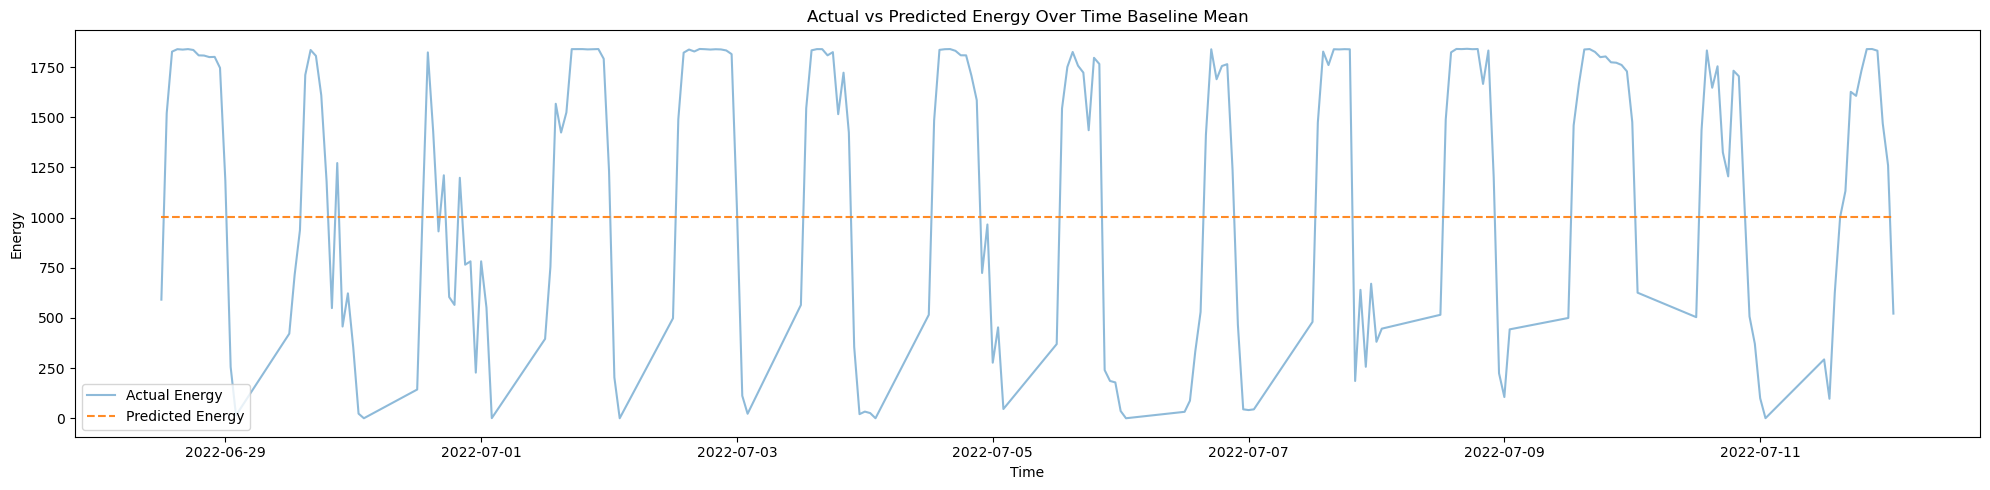

In [11]:
days = SolarData22.index.unique()
random_start22 = np.random.choice(days)
end_day22 = random_start22+pd.Timedelta(days=14)

plt.figure(figsize=(20, 5))
plt.plot(SolarDataDay22.loc[random_start22:end_day22].index, baseline1_y[random_start22:end_day22]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(SolarDataDay22.loc[random_start22:end_day22].index, baseline1_y[random_start22:end_day22]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Baseline Mean")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

RMSE: 615.3348240206623
r2: -2.9295614711000066e+31


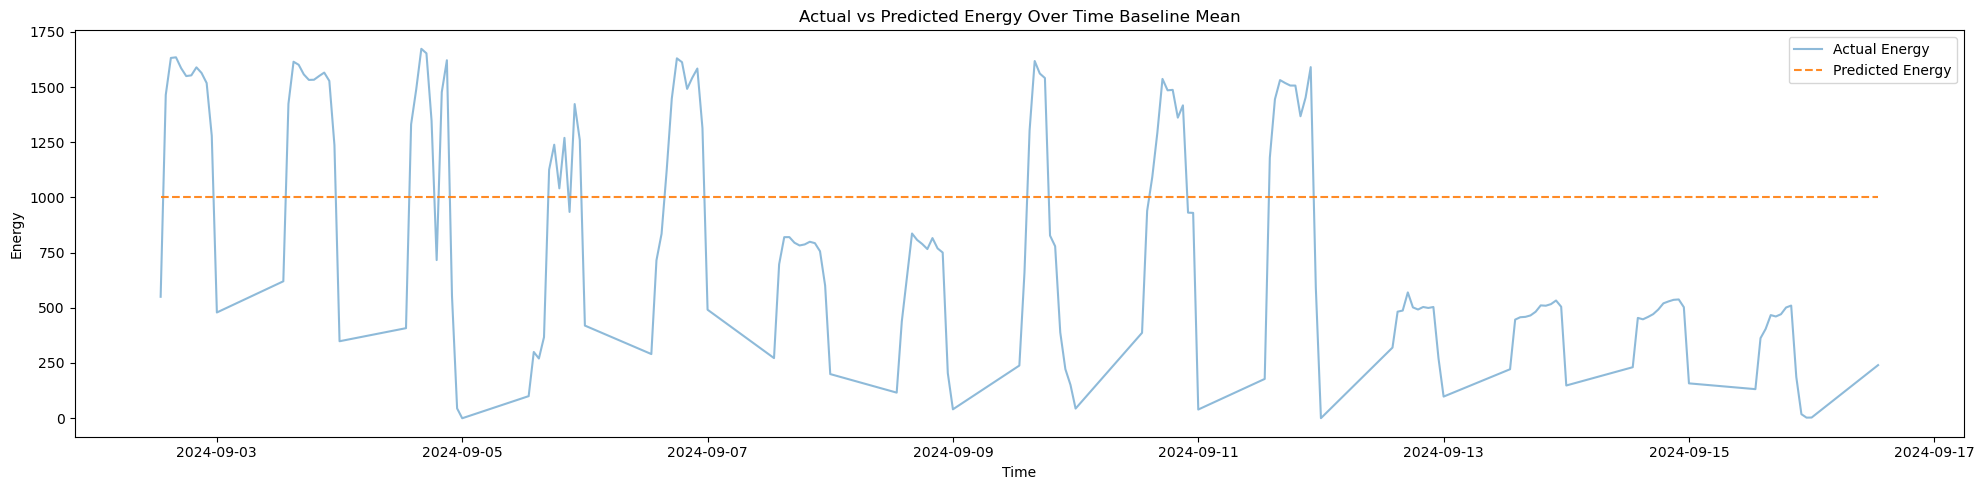

In [12]:
baseline1_x24 = SolarDataDay24[['Solar Zenith Angle']].copy()
baseline1_y24 = SolarDataDay24[['Energy']].copy()

baseline1_y24['Prediction'] = baseline1.predict(baseline1_x24)

days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

print("RMSE:", root_mean_squared_error(baseline1_y24['Prediction'],baseline1_y24['Energy']))
print("r2:", r2_score(baseline1_y24['Prediction'],baseline1_y24['Energy']))

plt.figure(figsize=(20, 5))
plt.plot(SolarDataDay24.loc[random_start24:end_day24].index, baseline1_y24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(SolarDataDay24.loc[random_start24:end_day24].index, baseline1_y24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Baseline Mean")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

Moving Average RMSE: 638.4135039434759
Moving Average r2: 0.006964507464719549


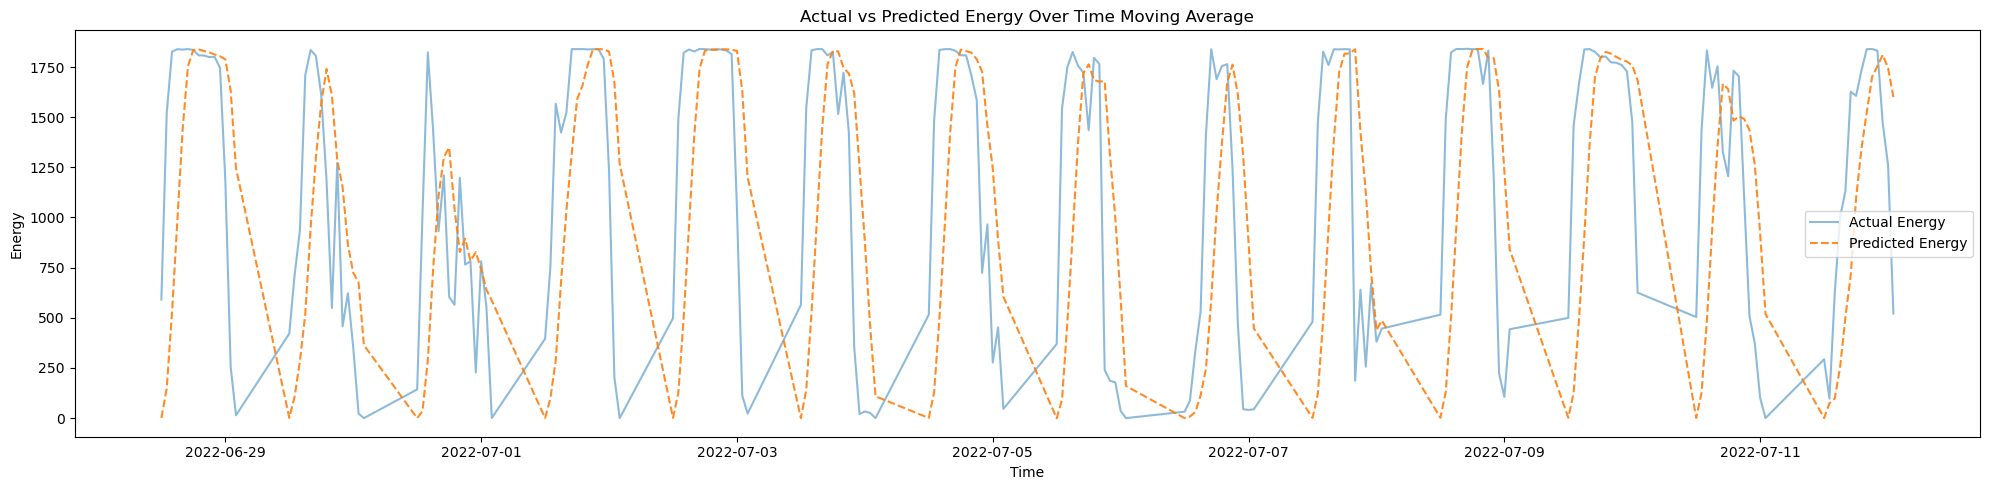

In [13]:
SolarData22MA = SolarData22.copy()

SolarData22MA['Energy Moving Average'] = SolarData22MA['Energy'].shift(1).rolling(window=4).mean()
SolarData22MA.dropna(inplace=True)
SolarData22MA = SolarData22MA[SolarData22MA['Solar Zenith Angle']<np.pi/2]

print("Moving Average RMSE:", root_mean_squared_error(SolarData22MA['Energy'], SolarData22MA['Energy Moving Average']))
print("Moving Average r2:", r2_score(SolarData22MA['Energy'], SolarData22MA['Energy Moving Average']))

plt.figure(figsize=(20, 5))
plt.plot(SolarData22MA.loc[random_start22:end_day22].index, SolarData22MA[random_start22:end_day22]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(SolarData22MA.loc[random_start22:end_day22].index, SolarData22MA[random_start22:end_day22]['Energy Moving Average'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Moving Average")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 4, 10],
    'min_samples_leaf': [2, 3, 4, 10],
    'max_features': ['sqrt', 'log2',2,3,1.0]
}

In [15]:
X_1_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_1_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=RandomForestRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_1_22,y_1_22)

print("Best parameters:", search.best_params_)
model_1 = search.best_estimator_

rmse_scores1 = cross_val_score(model_1, X_1_22, y_1_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores1)
print("Average RMSE:", -rmse_scores1.mean())

r2_scores1 = cross_val_score(model_1, X_1_22, y_1_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores1)
print("Average r2:", r2_scores1.mean())

Best parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 5}
Average RMSE: 345.5415853353257
Average r2: 0.6668741308261061


RMSE: 357.88863180008536
r2: 0.6568137606178992


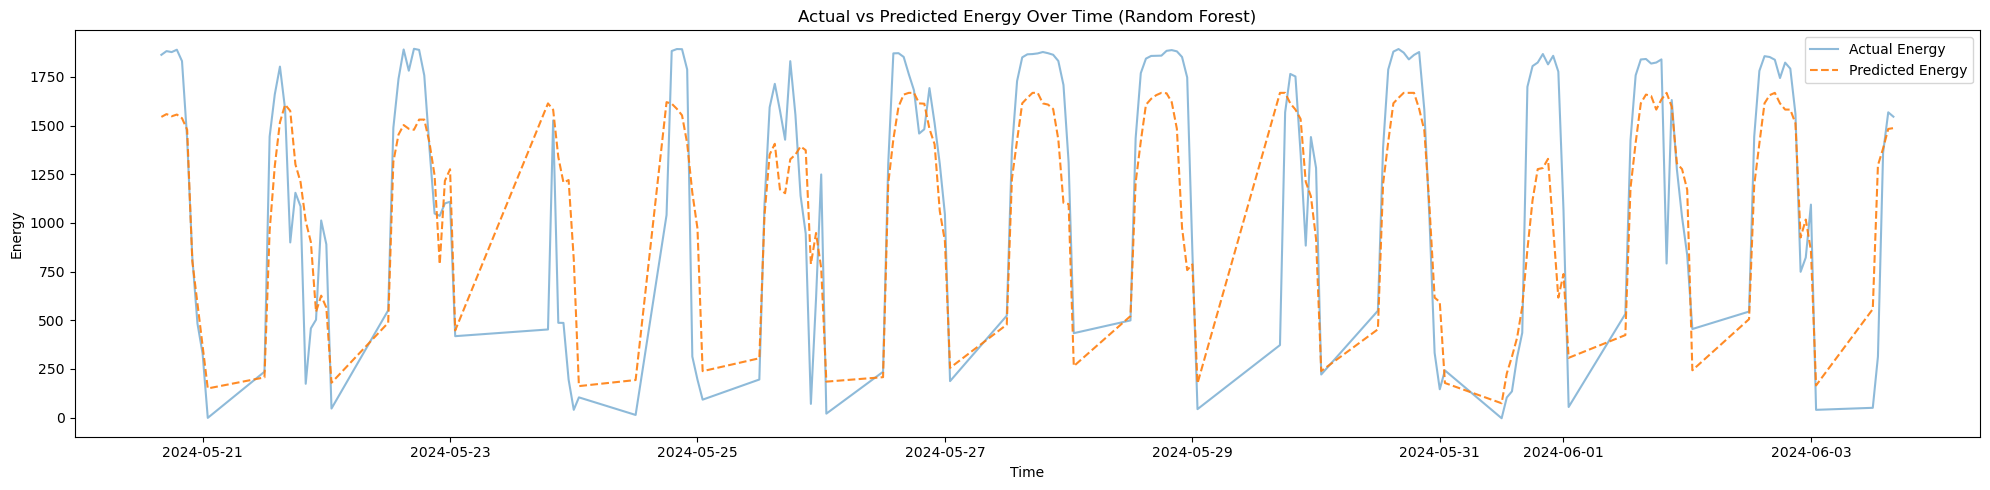

In [ ]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_1_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_1_24 = SolarDataDay24[['Energy']].copy()

y_1_24['Prediction'] = model_1.predict(X_1_24)

print('RMSE:',root_mean_squared_error(y_1_24.iloc[:,0],y_1_24.iloc[:,1]))
print('r2:',r2_score(y_1_24.iloc[:,0],y_1_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_1_24.loc[random_start24:end_day24].index, y_1_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_1_24.loc[random_start24:end_day24].index, y_1_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Random Forest)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [312]:
X_2_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_2_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=RandomForestRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_2_22,y_2_22)

print("Best parameters:", search.best_params_)
model_2 = search.best_estimator_

rmse_scores2 = cross_val_score(model_2, X_2_22, y_2_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -r2_scores2)
print("Average RMSE:", -rmse_scores2.mean())

r2_scores2 = cross_val_score(model_2, X_2_22, y_2_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores2)
print("Average r2:", r2_scores2.mean())

Best parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 10}
Average RMSE: 338.81170792514706
Average r2: 0.6812676144396208


RMSE: 353.7586088475411
r2: 0.664688773882143


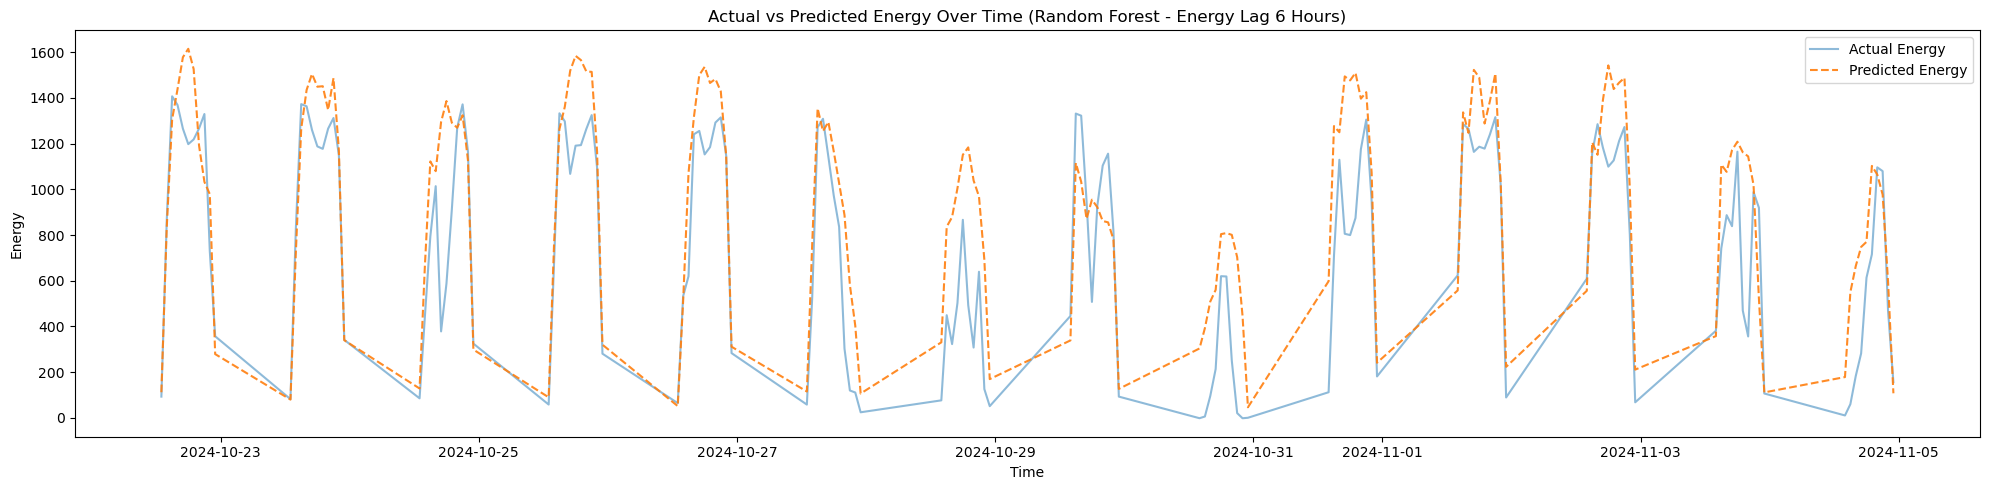

In [340]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_2_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_2_24 = SolarDataDay24[['Energy']].copy()

y_2_24['Prediction'] = model_2.predict(X_2_24)

print('RMSE:',root_mean_squared_error(y_2_24.iloc[:,0],y_2_24.iloc[:,1]))
print('r2:',r2_score(y_2_24.iloc[:,0],y_2_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_2_24.loc[random_start24:end_day24].index, y_2_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_2_24.loc[random_start24:end_day24].index, y_2_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Random Forest - Energy Lag 6 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [317]:
X_3_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6','Energy Lag 24']]
y_3_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=RandomForestRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_3_22,y_3_22)

print("Best parameters:", search.best_params_)
model_3 = search.best_estimator_

rmse_scores3 = cross_val_score(model_3, X_3_22, y_3_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores3)
print("Average RMSE:", -rmse_scores3.mean())

r2_scores3 = cross_val_score(model_3, X_3_22, y_3_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores3)
print("Average r2:", r2_scores3.mean())

Best parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10}
Average RMSE: 328.70146382659675
Average r2: 0.7033954060723879


RMSE: 339.6377082732299
r2: 0.6909235875965078


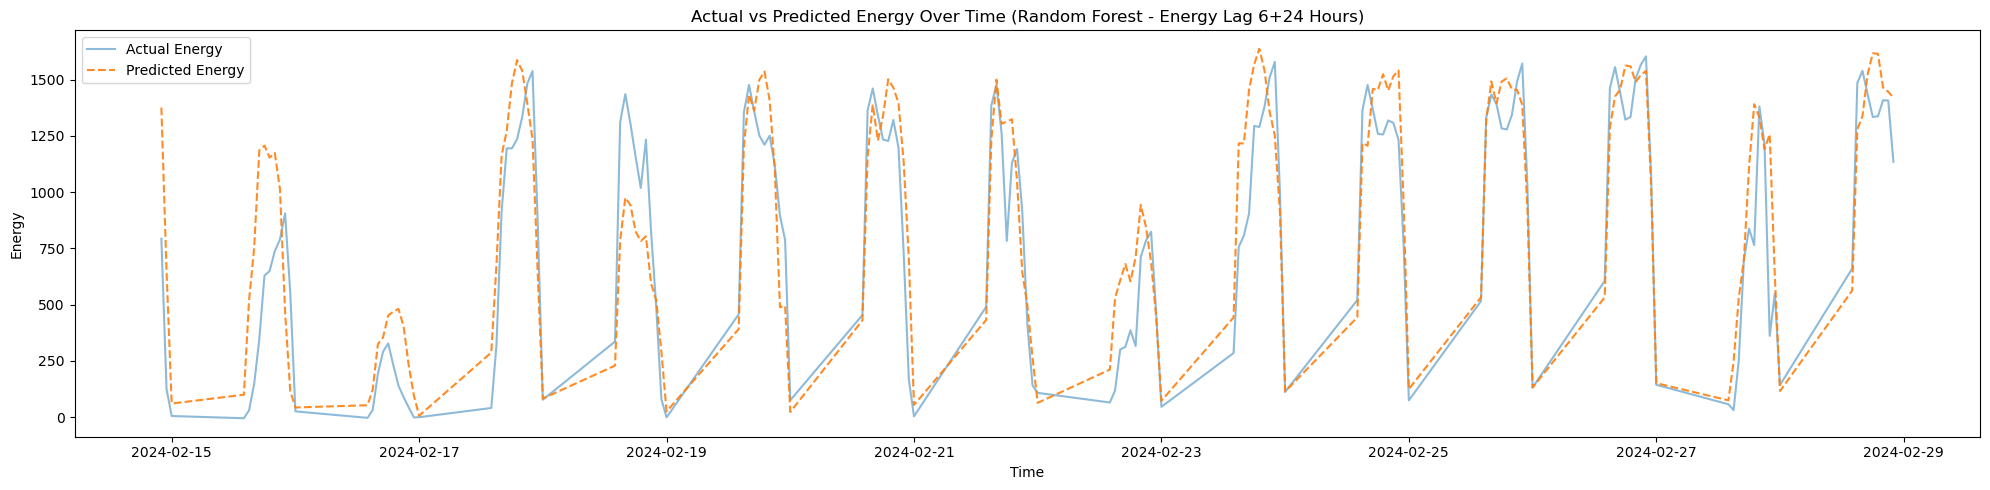

In [339]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_3_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6','Energy Lag 24']]
y_3_24 = SolarDataDay24[['Energy']].copy()

y_3_24['Prediction'] = model_3.predict(X_3_24)

print('RMSE:',root_mean_squared_error(y_3_24.iloc[:,0],y_3_24.iloc[:,1]))
print('r2:',r2_score(y_3_24.iloc[:,0],y_3_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_3_24.loc[random_start24:end_day24].index, y_3_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_3_24.loc[random_start24:end_day24].index, y_3_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Random Forest - Energy Lag 6+24 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [322]:
X_4_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']]
y_4_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=RandomForestRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_4_22,y_4_22)

print("Best parameters:", search.best_params_)
model_4 = search.best_estimator_

rmse_scores4 = cross_val_score(model_4, X_4_22, y_4_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores4)
print("Average RMSE:", -rmse_scores4.mean())

r2_scores4 = cross_val_score(model_4, X_4_22, y_4_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores4)
print("Average r2:", r2_scores4.mean())

Best parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 2, 'max_depth': 10}
Average RMSE: 332.4475149110357
Average r2: 0.6956972877732223


RMSE: 342.455186242004
r2: 0.6857744071290084


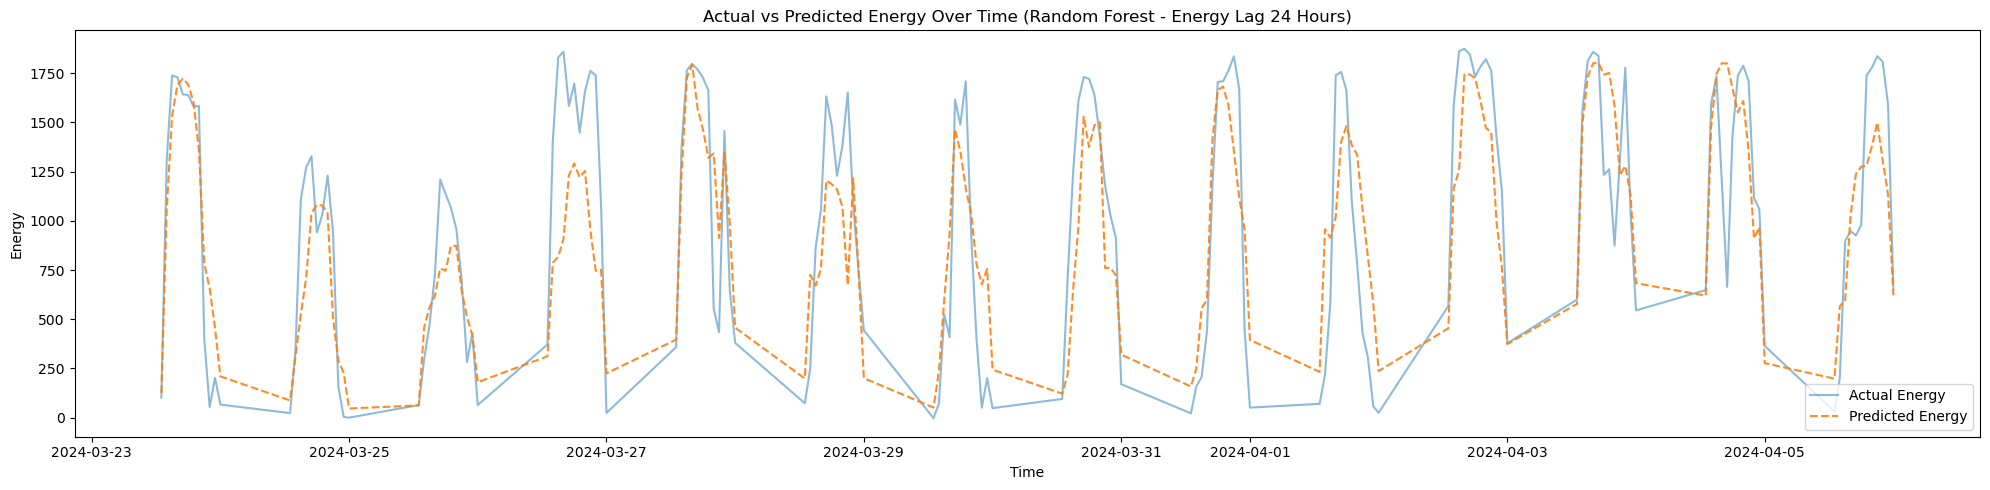

In [338]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_4_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']]
y_4_24 = SolarDataDay24[['Energy']].copy()

y_4_24['Prediction'] = model_4.predict(X_4_24)

print('RMSE:',root_mean_squared_error(y_4_24.iloc[:,0],y_4_24.iloc[:,1]))
print('r2:',r2_score(y_4_24.iloc[:,0],y_4_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_4_24.loc[random_start24:end_day24].index, y_4_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_4_24.loc[random_start24:end_day24].index, y_4_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Random Forest - Energy Lag 24 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [334]:
from sklearn.ensemble import ExtraTreesRegressor

param_dist = {
    'n_estimators': [20, 50, 100, 200, 500],
    'max_depth': [2, 5, 10, 15],
    'min_samples_split': [3, 4, 10],
    'min_samples_leaf': [3, 4, 10],
    'max_features': ['sqrt', 'log2',2,3,1.0],
}

In [335]:
X_5_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']]
y_5_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=ExtraTreesRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_5_22,y_5_22)

print("Best parameters:", search.best_params_)
print("Best score:", -search.best_score_)
model_5 = search.best_estimator_

rmse_scores5 = cross_val_score(model_5, X_5_22, y_5_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores5)
print("Average RMSE:", -rmse_scores5.mean())

r2_scores5 = cross_val_score(model_5, X_5_22, y_5_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores5)
print("Average r2:", r2_scores5.mean())

Best parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best score: 328.8147323060955
Average RMSE: 330.4263056584034
Average r2: 0.6987942133390472


RMSE: 339.5395047069324
r2: 0.6911022957737081


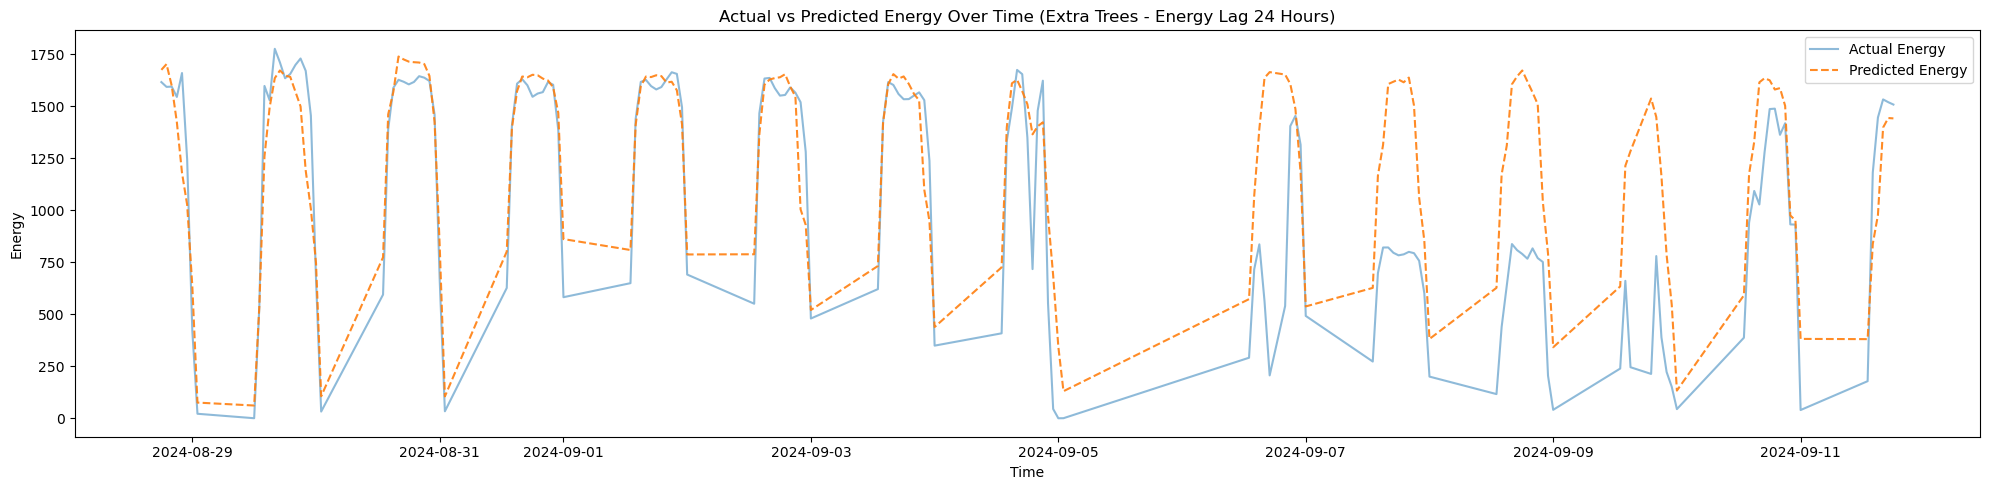

In [357]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_5_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']]
y_5_24 = SolarDataDay24[['Energy']].copy()

y_5_24['Prediction'] = model_5.predict(X_5_24)

print('RMSE:',root_mean_squared_error(y_5_24.iloc[:,0],y_5_24.iloc[:,1]))
print('r2:',r2_score(y_5_24.iloc[:,0],y_5_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_5_24.loc[random_start24:end_day24].index, y_5_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_5_24.loc[random_start24:end_day24].index, y_5_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Extra Trees - Energy Lag 24 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [342]:
X_6_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6','Energy Lag 24']]
y_6_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=ExtraTreesRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_6_22,y_6_22)

print("Best parameters:", search.best_params_)
print("Best score:", -search.best_score_)
model_6 = search.best_estimator_

rmse_scores6 = cross_val_score(model_6, X_6_22, y_6_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores6)
print("Average RMSE:", -rmse_scores6.mean())

r2_scores6 = cross_val_score(model_6, X_6_22, y_6_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores6)
print("Average r2:", r2_scores6.mean())

Best parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 1.0, 'max_depth': 10}
Best score: 325.73347637380726
Average RMSE: 326.08229557227025
Average r2: 0.7080986310334751


RMSE: 335.62845474029984
r2: 0.6981775043569209


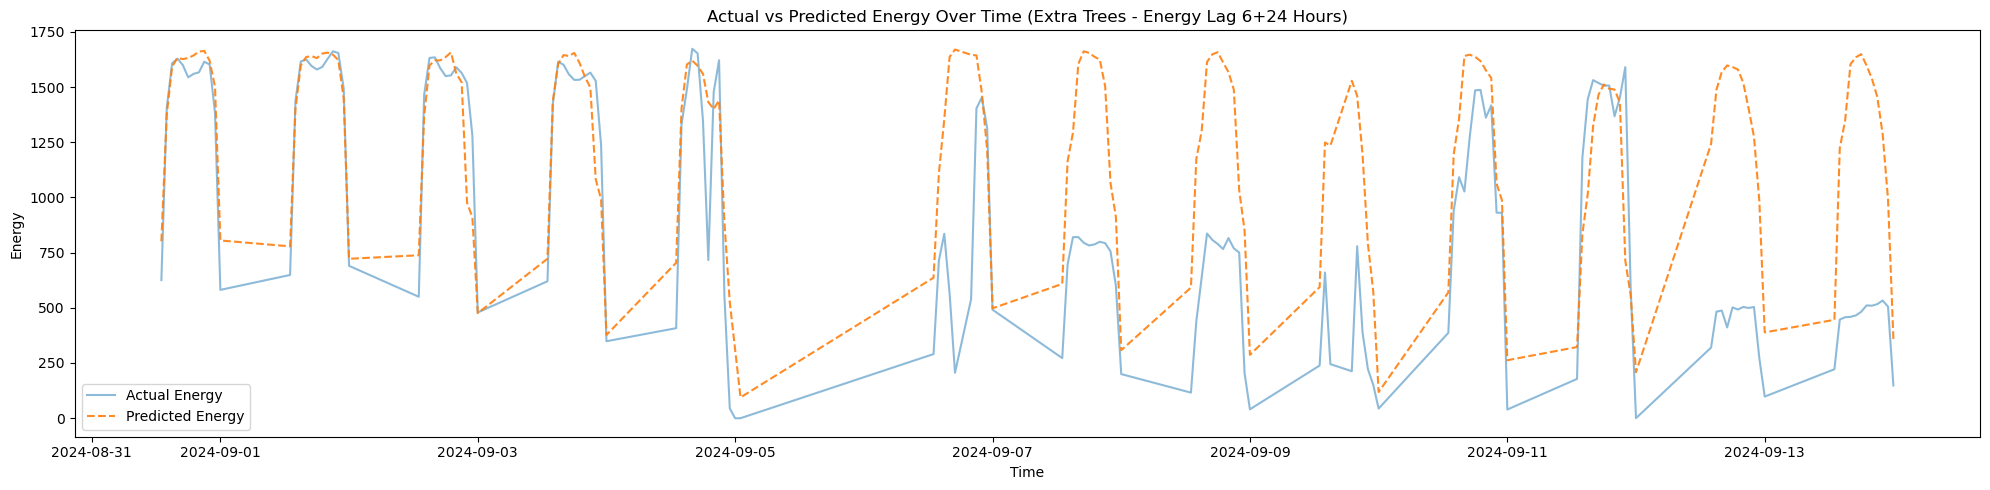

In [ ]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_6_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6','Energy Lag 24']]
y_6_24 = SolarDataDay24[['Energy']].copy()

y_6_24['Prediction'] = model_6.predict(X_6_24)

print('RMSE:',root_mean_squared_error(y_6_24.iloc[:,0],y_6_24.iloc[:,1]))
print('r2:',r2_score(y_6_24.iloc[:,0],y_6_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_6_24.loc[random_start24:end_day24].index, y_6_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_6_24.loc[random_start24:end_day24].index, y_6_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Extra Trees - Energy Lag 6+24 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [394]:
X_7_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 3']]
y_7_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=ExtraTreesRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_7_22,y_7_22)

print("Best parameters:", search.best_params_)
print("Best score:", -search.best_score_)
model_7 = search.best_estimator_

rmse_scores7 = cross_val_score(model_7, X_7_22, y_7_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores7)
print("Average RMSE:", -rmse_scores7.mean())

r2_scores7 = cross_val_score(model_7, X_7_22, y_7_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores7)
print("Average r2:", r2_scores7.mean())

Best parameters: {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 3, 'max_depth': 15}
Best score: 332.37399226579447
Average RMSE: 332.8153933806353
Average r2: 0.6952227778973598


RMSE: 344.3613926004621
r2: 0.6822665270123536


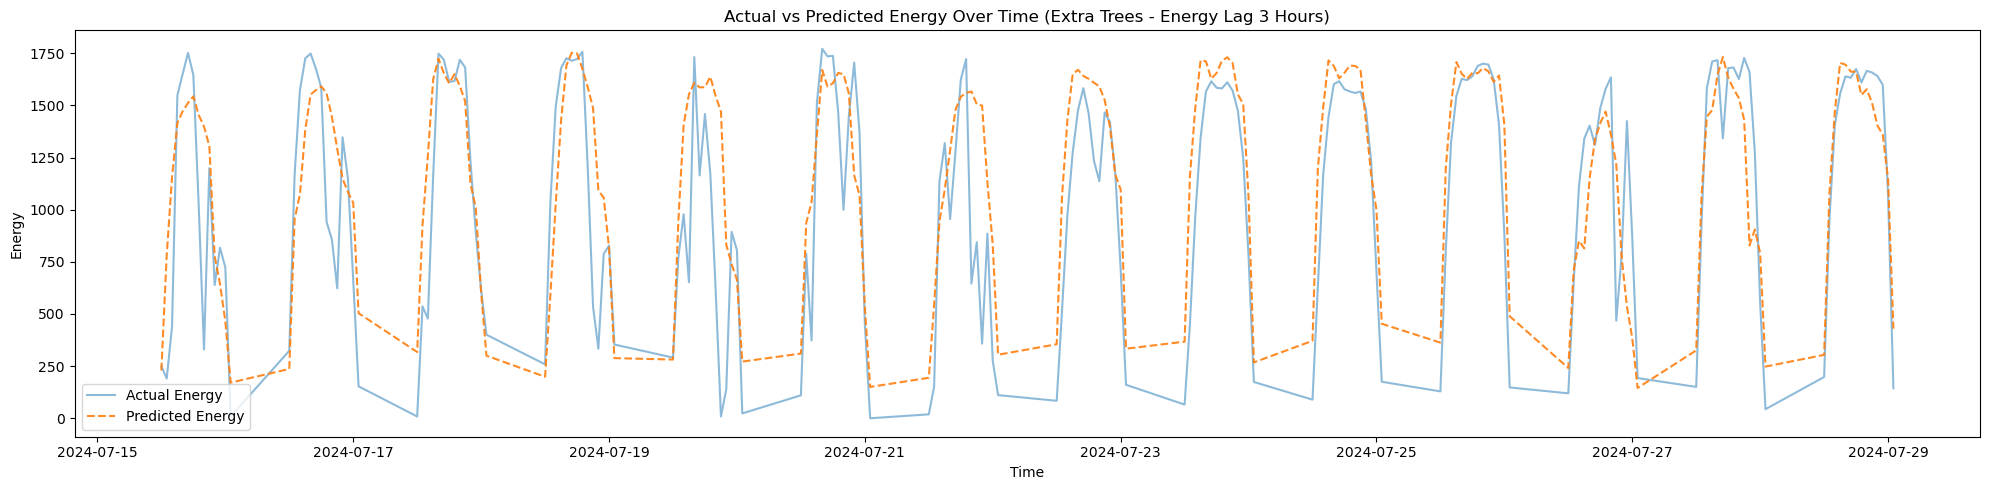

In [395]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_7_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 3']]
y_7_24 = SolarDataDay24[['Energy']].copy()

y_7_24['Prediction'] = model_7.predict(X_7_24)

print('RMSE:',root_mean_squared_error(y_7_24.iloc[:,0],y_7_24.iloc[:,1]))
print('r2:',r2_score(y_7_24.iloc[:,0],y_7_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_7_24.loc[random_start24:end_day24].index, y_7_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_7_24.loc[random_start24:end_day24].index, y_7_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Extra Trees - Energy Lag 3 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X_8_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_8_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=ExtraTreesRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_8_22,y_8_22)

print("Best parameters:", search.best_params_)
print("Best score:", -search.best_score_)
model_8 = search.best_estimator_

rmse_scores8 = cross_val_score(model_8, X_8_22, y_8_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores8)
print("Average RMSE:", -rmse_scores8.mean())

r2_scores8 = cross_val_score(model_8, X_8_22, y_8_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores8)
print("Average r2:", r2_scores8.mean())

Best parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 10}
Best score: 335.29013752745277
Average RMSE: 335.5993305236105
Average r2: 0.6898702307123269


RMSE: 350.78562142440745
r2: 0.6703010030121533


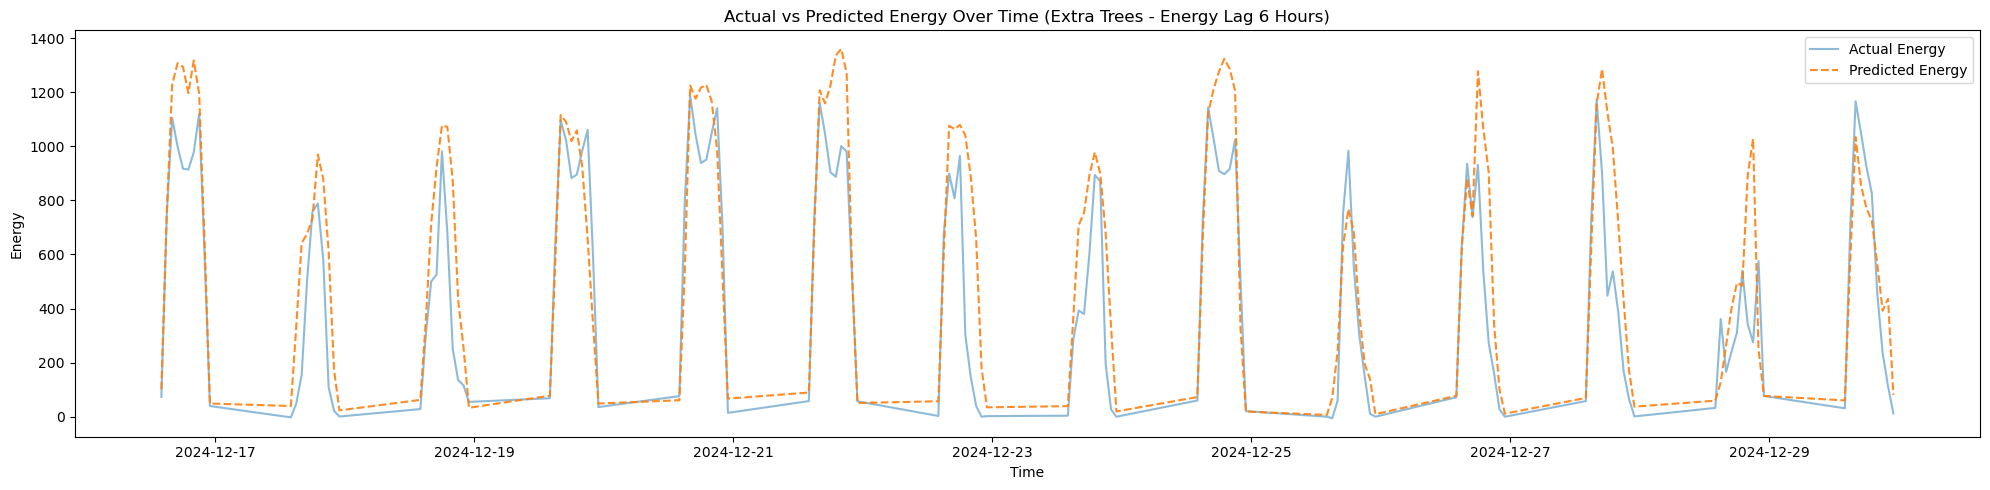

In [397]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_8_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_8_24 = SolarDataDay24[['Energy']].copy()

y_8_24['Prediction'] = model_8.predict(X_8_24)

print('RMSE:',root_mean_squared_error(y_8_24.iloc[:,0],y_8_24.iloc[:,1]))
print('r2:',r2_score(y_8_24.iloc[:,0],y_8_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_8_24.loc[random_start24:end_day24].index, y_8_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_8_24.loc[random_start24:end_day24].index, y_8_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Extra Trees - Energy Lag 6 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [398]:
X_9_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_9_22 = SolarDataDay22['Energy']

search = RandomizedSearchCV(estimator=ExtraTreesRegressor(),param_distributions=param_dist,n_iter=50,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X_9_22,y_9_22)

print("Best parameters:", search.best_params_)
print("Best score:", -search.best_score_)
model_9 = search.best_estimator_

rmse_scores9 = cross_val_score(model_9, X_9_22, y_9_22, cv=10, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores9)
print("Average RMSE:", -rmse_scores9.mean())

r2_scores9 = cross_val_score(model_9, X_9_22, y_9_22, cv=10, scoring='r2')

#print("r2 scores:", r2_scores9)
print("Average r2:", r2_scores9.mean())

Best parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 2, 'max_depth': 15}
Best score: 340.43843047870917
Average RMSE: 340.71691304863873
Average r2: 0.6806458199174608


RMSE: 354.1110772471983
r2: 0.6640202644178743


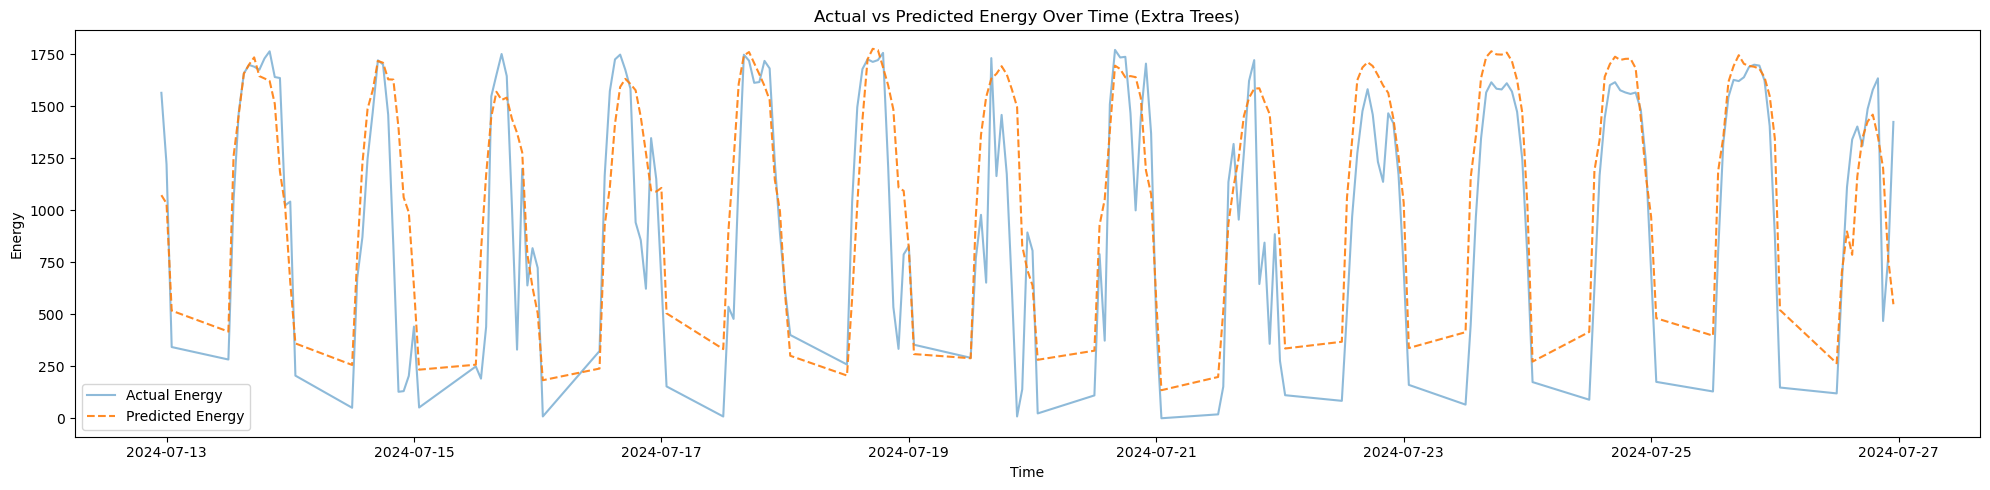

In [401]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

X_9_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_9_24 = SolarDataDay24[['Energy']].copy()

y_9_24['Prediction'] = model_9.predict(X_9_24)

print('RMSE:',root_mean_squared_error(y_9_24.iloc[:,0],y_9_24.iloc[:,1]))
print('r2:',r2_score(y_9_24.iloc[:,0],y_9_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_9_24.loc[random_start24:end_day24].index, y_9_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_9_24.loc[random_start24:end_day24].index, y_9_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Extra Trees)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from xgboost import XGBRegressor
from itertools import product

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 3, 5]
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

In [408]:
best_rmse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = None

X_train = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_train = SolarDataDay22[['Energy']]

X_test = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_test = SolarDataDay24[['Energy']]

for params in param_combinations:
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_rmse_model = model
        best_rmse_params = params

    if r2 > best_r2:
        best_r2 = r2
        best_r2_model = model
        best_r2_params = params

In [409]:
print("Best RMSE:", best_rmse)
print("Best Parameters:", best_rmse_params)

print("Best r2:", best_r2)
print("Best Parameters:", best_r2_params)

Best RMSE: 352.2793273925781
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 1, 'reg_lambda': 3}
Best r2: 0.6674871444702148
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 1, 'reg_lambda': 3}


RMSE: 352.27933618344144
r2: 0.6674871773676871


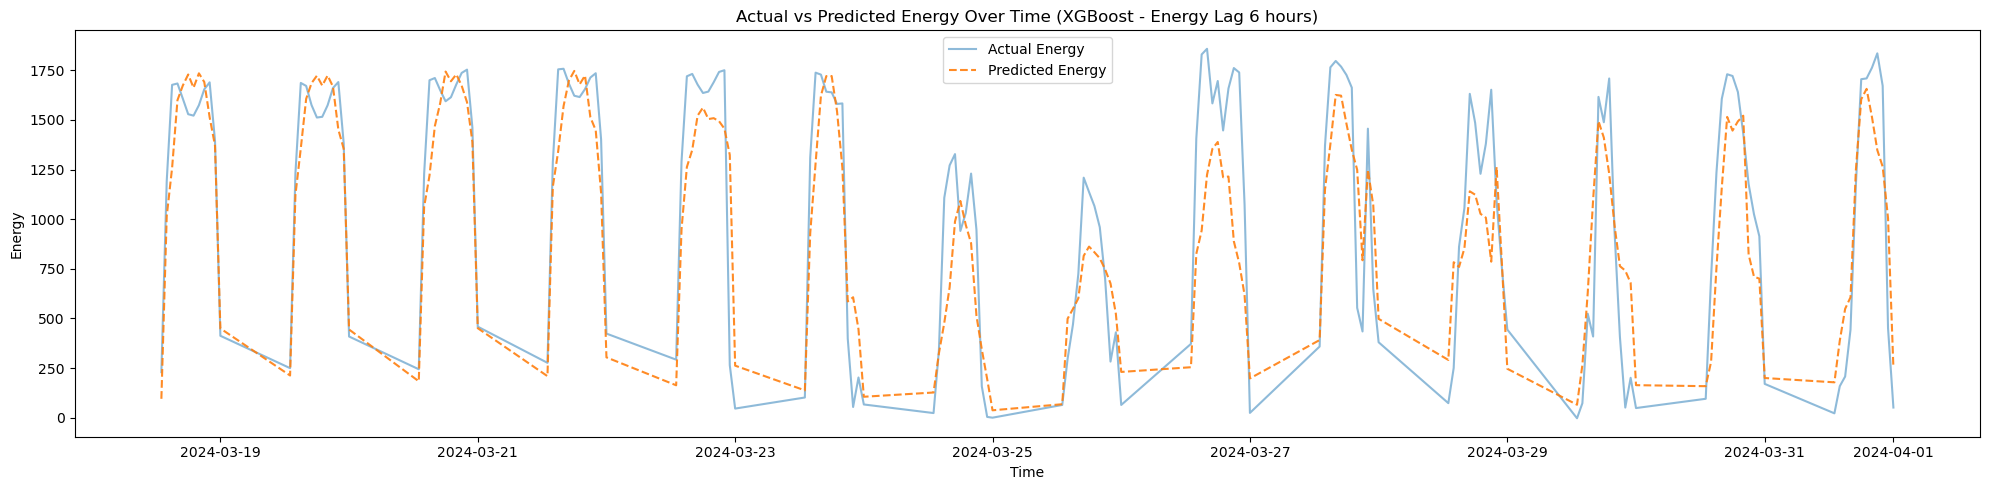

In [410]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_10 = XGBRegressor(**best_rmse_params)
model_10.fit(X_train,y_train)

X_10_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']]
y_10_24 = SolarDataDay24[['Energy']].copy()

y_10_24['Prediction'] = model_10.predict(X_10_24)

print('RMSE:',root_mean_squared_error(y_10_24.iloc[:,0],y_10_24.iloc[:,1]))
print('r2:',r2_score(y_10_24.iloc[:,0],y_10_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(X_10_24.loc[random_start24:end_day24].index, y_10_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(X_10_24.loc[random_start24:end_day24].index, y_10_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (XGBoost - Energy Lag 6 hours)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()